# Word2Vec Implementation

In [1]:
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk import word_tokenize
from gensim.models import Word2Vec as w2v
from sklearn.decomposition import PCA

In [2]:
# constants
PATH = 'data/shakespeare.txt'
sw = stopwords.words('english')
plt.style.use('ggplot')
# nltk.download('punkt')
# nltk.download('stopwords')

## Import Data

In [3]:
%%time
lines = []
with open(PATH, 'r') as f:
    for l in f:
        lines.append(l)

CPU times: user 15.4 ms, sys: 4.48 ms, total: 19.9 ms
Wall time: 21.7 ms


## Preprocessing

In [4]:
# remove new lines
lines = [line.rstrip('\n') for line in lines]

# make all characters lower
lines = [line.lower() for line in lines]

# remove punctuations from each line
lines = [line.translate(str.maketrans('', '', string.punctuation)) for line in lines]

Source : https://stackoverflow.com/questions/54929726/word2vec-vocab-results-in-just-letters-and-symbols  

As the tutorial and the documentation for Word2Vec class suggests the constructor of the class requires list of lists of words as the first parameter (or iterator of iterators of words in general):

sentences (iterable of iterables, optional) – The sentences iterable can be simply a list of lists of tokens, but for larger corpora,...

I believe before feeding in sentences into Word2Vec you need to use words_tokenize on each of the sentences changing the crucial line to:

sentences = [nltk.word_tokenize(sent) for sent in nltk.sent_tokenize(text)]
TL;DR

You get letters as your "words" because Word2Vec treats strings corresponding to sentences as iterables containing words. Iterating over strings results in the sequence of letters. These letters are used as the basis for the model learning (instead of intended words).

As the ancient saying goes: trash in - trash out.

In [5]:
%time lines = [nltk.word_tokenize(sent) for sent in lines]

CPU times: user 6.62 s, sys: 32 ms, total: 6.65 s
Wall time: 6.65 s


**Note**  

Be aware that the stopwords removed from these lines are of modern vocabulary. The application & data has a high importance to the type of preprocessing tactics necessary for cleaning of words.   

In our scenario, words like "you" or "yourself" would be present in the stopwords and eliminated from the lines, however since this is shakesperes text data, these types of words would not be used. Instead "thou" or "thyself" might be useful to remove. Stay keen to these types of minature changes because they make a drastic difference in the performance of a good model versus a poor one.   

For the purposes of this example, I won't be going into extreme details in identifying stopwords from a different centuary, but be aware that you should. 

In [6]:
def remove_stopwords(lines, sw = sw):
    '''
    The purpose of this function is to remove stopwords from a given array of 
    lines.
    
    params:
        lines (Array / List) : The list of lines you want to remove the stopwords from
        sw (Set) : The set of stopwords you want to remove
        
    example:
        lines = remove_stopwords(lines = lines, sw = sw)
    '''
    
    res = []
    for line in lines:
        original = line
        line = [w for w in line if w not in sw]
        if len(line) < 1:
            line = original
        res.append(line)
    return res
    

In [7]:
%time filtered_lines = remove_stopwords(lines = lines, sw = sw)

CPU times: user 1.18 s, sys: 6.53 ms, total: 1.18 s
Wall time: 1.18 s


## Word2Vec

In [8]:
%%time
w = w2v(
    lines,
    min_count=3,   # Ignore words that appear less than this
    sg = 1,        # skipgrams
    window=7       # Context window for words during training
)       

CPU times: user 12.9 s, sys: 52.6 ms, total: 13 s
Wall time: 4.64 s


In [9]:
w.wv.most_similar('thou')

[('thyself', 0.7645957469940186),
 ('art', 0.707123875617981),
 ('dost', 0.6897317171096802),
 ('wouldst', 0.6642480492591858),
 ('wilt', 0.6552817225456238),
 ('villain', 0.651666522026062),
 ('didst', 0.6509525775909424),
 ('shalt', 0.6448981165885925),
 ('canst', 0.6428443789482117),
 ('damned', 0.6254445314407349)]

In [10]:
%%time
emb_df = (
    pd.DataFrame(
        [w.wv.get_vector(str(n)) for n in w.wv.key_to_index],
        index = w.wv.key_to_index
    )
)

CPU times: user 1.18 s, sys: 244 ms, total: 1.43 s
Wall time: 250 ms


In [11]:
emb_df.shape

(11676, 100)

In [12]:
emb_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
the,0.052167,0.360179,0.251422,0.088310,0.007917,-0.391403,0.167161,0.353071,0.035659,0.307231,...,0.286352,-0.106132,0.027149,0.040260,0.306436,0.119667,0.053033,-0.028715,0.081309,0.316534
and,-0.106972,0.224614,0.366498,-0.109355,0.058367,-0.345540,-0.177559,0.474959,-0.180183,-0.060948,...,0.457157,-0.168714,0.422513,-0.284481,0.416731,0.196803,0.176352,-0.251699,-0.124210,0.052072
i,-0.219191,-0.083908,-0.122480,-0.024484,-0.082866,-0.074146,0.068647,0.249081,-0.552616,-0.142015,...,-0.056736,0.315569,0.291890,-0.402557,0.307429,0.560778,-0.039935,0.080511,0.172005,-0.205800
to,-0.306866,-0.038027,0.101534,-0.328933,0.246991,-0.279042,-0.169662,0.556220,-0.267376,-0.142015,...,0.134588,0.094954,0.135004,0.044490,0.338002,0.067672,0.292339,-0.027994,0.276851,-0.083303
of,-0.337473,0.150470,0.202975,-0.009964,0.149471,-0.243055,0.247682,0.350076,-0.037486,0.208371,...,0.192981,-0.071674,0.005496,-0.351363,0.400210,-0.245767,0.172492,-0.156913,0.124116,-0.247358


### Visualize Embedding

<Figure size 432x288 with 0 Axes>

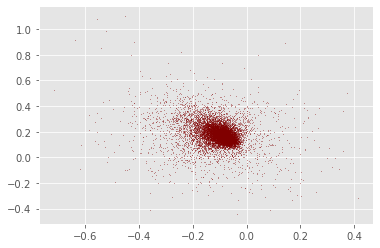

In [13]:
plt.clf()
fig=plt.figure(figsize=(6,4))
plt.scatter(
    x = emb_df.iloc[:,0],
    y = emb_df.iloc[:,1],
    s = 0.2,
    color = 'maroon',
    alpha = 0.5
)
plt.show()


### PCA

In [14]:
pca = PCA(n_components=2, random_state=7)
pca_mdl = pca.fit_transform(emb_df)

In [15]:
emb_df_PCA = (
    pd.DataFrame(
        pca_mdl,
        columns=['x','y'],
        index = emb_df.index
    )
)

[]

<Figure size 432x288 with 0 Axes>

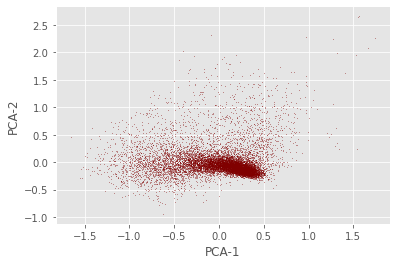

In [16]:
plt.clf()
fig = plt.figure(figsize=(6,4))

plt.scatter(
    x = emb_df_PCA['x'],
    y = emb_df_PCA['y'],
    s = 0.2,
    color = 'maroon',
    alpha = 0.5
)

plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.plot()
